In [16]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
sns.set_style("whitegrid")

This is merely a description of the analysis done on June 13th,14th, and 15th 2016, trying to match a Model signal to a Dataset. We essentially varied the four different variables (q,a,p,T) to change the Model. Then we compared the chi-squared values of the Model and the Dataset. The lowest chi-squared value would be the combination of the four variables that led to a Model that was most similar to the Dataset.

Mira

In [17]:
file=open( '../../data/raw_data/20160428_1313_W1204_ref.pkl' , 'rb')
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

In [18]:
def psi0(z_not,q,p): 
    z = t
    y0=-np.cos(2*np.pi*q*(z-z_not))*(np.exp(-((z-z_not)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    return z,y0

The Model equation we chose was 
y0=-np.cos(2*pi*q*(z-z_not))*(e^(-((z-z_not)^2)/(2*p^2)))/(sqrt(2*pi)*p)
It is clearly dependent on three variables; z_not, q, and p. z_not shifts the Model on the x-axis. q determines the frequency of oscillation. p determines the width of the Model. 
However it is clear from the plot below (with z_not, q, and p chosen by eye) that there is also an important scale factor, which we called A. 

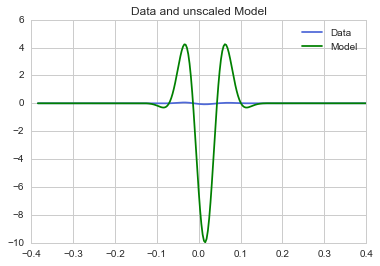

In [79]:
pl.plot(t,D, label = 'Data')
x,Model = psi0(0.015,8.72718120805,0.04)
pl.plot(x,Model, label = 'Model', color = 'g')
pl.xlim(-0.4,0.4)
pl.title('Data and unscaled Model')
pl.legend()
pl.show()

We multiplied it by different scale factors, an example being the plot below having A = .005, and reached a range of A values that seemed to match the Model to the Data.

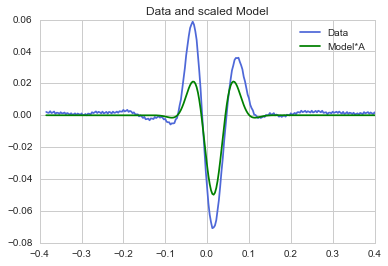

In [49]:
pl.plot(t,D, label = 'Data')
pl.plot(x,Model*.005, label = 'Model*A', color = 'g')
pl.xlim(-0.4,0.4)
pl.title('Data and scaled Model')
pl.legend()
pl.show()

We then began  trying to find the best value for the variable q, and its respective scale factor A. To do this we minimized the chi-squared of the non-convoluted Model and the Dataset.

We spanned A values from .00001 to .02, and q values from 4 to 26. These were the values that seemed most likely just by looking at the plots by eye. 
We created a contour plot from the data and discovered a minimum and its subsequent two values.

In [25]:
avec = np.linspace(0.00001,0.02, 110) #possible a values
qvec = np.linspace(4.0,26.0,150) #possible q values
ChiMat= np.zeros((len(qvec),len(avec)))

for ii in range (0,len(qvec)):
    for jj in range (0, len(avec)):
        q = qvec[ii]
        a = avec[jj]
        x,Model = psi0(.015,q,0.04)
        Dev = np.dot((D-Model*a),D-Model*a)
        #Sig = (0.01)*(255) #average variance
        ChiMat[ii,jj] = Dev

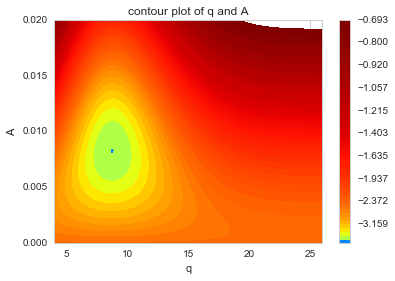

In [51]:
levs=np.log(np.linspace(0.0001,0.5,60))
pl.contourf(qvec,avec,np.log(ChiMat.T), levels=levs,cmap=pl.cm.jet)
pl.title('contour plot of q and A')
pl.xlabel('q')
pl.ylabel('A')
pl.colorbar()
pl.show()

The values of q and A at the minimum of the chi-squared matrix are 8.724 and .00826 respectively. 
Plugging in these values to Model, with p = .04 and z_not = .015, returned the following plot.  

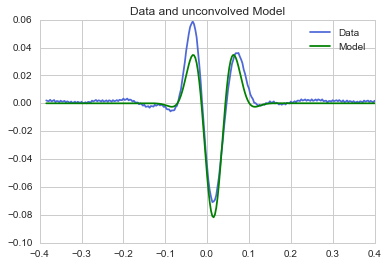

In [78]:
pl.plot(t,D, label = 'Data')
x,Model = psi0(0.015,8.724,0.04)
pl.plot(x,Model*.0082, label = 'Model', color = 'g')
pl.xlim(-0.4,0.4)
pl.title('Data and unconvolved Model')
pl.legend()
pl.show()

Of course this is trying to matched an un-convolved Model to convolved Data. Therefore, to increase the accuracy of our Model, we convolved it mathematically by hand and through mathematica. 

We then convolved it in python by taking the inverse fourier transform of the fourier transform multiplied by the original function and the fourier transform of the kernel. This avoids the need for integration.

To make sure that the python convolution of the Model was the same as the Mathematica convolution of the Model, we plotted both and changed different variables to make sure that both the plots and the variable's effects on the plots were the same. 

In [37]:
def psi1(z_not,q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    y0=-np.cos(2*np.pi*q*(z-z_not))*(np.exp(-((z-z_not)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_f = T/(1+(1j*2*np.pi*f_full*T))
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return z,y1

In [38]:
def findznot(P,T): #this is z_not written as a function of tau
    Znotvec = np.linspace(-.026,.026,150)
    MinzNot = np.zeros((len(Znotvec)))
    for kk in range (0,len(Znotvec)):
        z_not = Znotvec[kk]
        x,Modelf = psi1(z_not,8.57718120805,P, T)
        ModelMin = np.where(Modelf == Modelf.min())
        ModelMin = ModelMin[0]
        ModelMin = ModelMin[0]
        DataMin = np.where(D == D.min())
        DataMin = DataMin[0]
        DataMin = DataMin[0]
        MinzNot[kk] = np.abs(1-(float(ModelMin)/float(DataMin)))
    miin = np.where(MinzNot == MinzNot.min())
    miin = miin[0]
    miin = miin[0]
    BestzNot = Znotvec[miin]
    return BestzNot

In [40]:
def findahat(P,T):
    x,Modelf = psi1(findznot(P,T),8.57718120805,P,T) #z_not, q, p, T
    Mult = np.dot(D,Modelf)
    Mult2 = np.dot(Modelf,Modelf)
    aHat=Mult/Mult2
    return aHat
        #print p,T,aHat #for some reason aHat seems smaller than it should be? .05 instead of .08?

After doing this, we got a function for a convoluted Model: Modelf. This function is dependent on z_not, q, p, and Tau (T). However, q we know from optimizing the non-convoluted Model, and z_not can be shown to be a function of T. Therefore given q prior, Modelf becomes a function of two parameters.

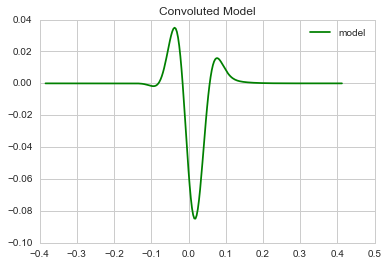

In [80]:
x,Modelf = psi1(0,8.277,0.04,0.03) #original q: 8.57718120805
pl.plot(x,Modelf*.08, label = 'model', color='g')
pl.title('Convoluted Model')
pl.legend()
pl.show()

It was noted that z_not was a function of T. This is shown in the plot below where T varies from .001 to .1, and the plot moves along the x axis due to changes in z_not. 

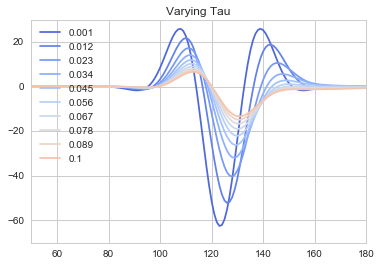

In [63]:
Tvec = np.linspace(0.001,0.1, 10)

for tt in Tvec:
    x,Modelf = psi1(0,8.57718120805,.04, tt)/tt
    pl.plot(Modelf,'-', label=str(tt))
pl.xlim(50, 180)
pl.title('Varying Tau')
pl.legend(loc='upper left')
pl.show()

P, the other parameter we were trying to optimize, does not affect z_not. As shown in the plot below, varying p does not affect the position of the graph on the x axis.

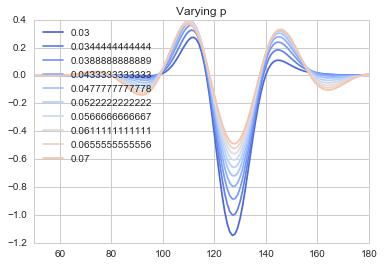

In [65]:
pvec = np.linspace(.03,.07,10)

for tt in pvec:
    x,Modelf = psi1(0,8.57718120805,tt, .02)
    pl.plot(Modelf,'-', label=str(tt))
pl.xlim(50, 180)
pl.title('Varying p')
pl.legend(loc='upper left')
pl.show()

To make z_not dependent on T, we wrote a function that took two variables, p and T,and matched the minimum of Modelf to the minimum of the Dataset.

That is, as both Modelf and the Dataset are  convoluted, we want the minimums of the functions to line up. So our function takes a p and T value and runs through the set of z_not values we deemed appropriate and returns whatever z_not value makes the minimums of the Model and Dataset line up. 

We did the same for A. It was noted that A was a function of p and T as well. In the plots shown again below, both p and T change the amplitude of the model. This is obvious from the chi-squared formula. 

Therefore we solved the chi-squared formula for the optimal A, and made it a function. It that takes a p and T value and returns the best A value. 

Now everything is in terms of p and T, and we can create a chi-squared contour plot to optimize p and T values. 

In [66]:
pvec = np.linspace(0.04,.07,30)
Tvec = np.linspace(.001,.08, 40)

ChiMat= np.zeros((len(pvec),len(Tvec)))
for ii in range (0,len(pvec)):
    for jj in range (0, len(Tvec)):
        p = pvec[ii]
        T = Tvec[jj]
        x,Modelf = psi1(findznot(p,T),8.57718120805,p, T)
        Dev = np.dot((D-Modelf*(findahat(p,T))),D-Modelf*(findahat(p,T)))
        ChiMat[ii,jj] = Dev

[]


(30, 40, (30, 40))


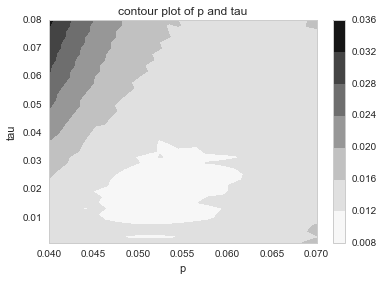

In [68]:
levs=(np.linspace(0.001,.1,80))

print(len(pvec), len(Tvec), np.shape(ChiMat))
pl.contourf(pvec,Tvec,(ChiMat.T))
pl.xlabel('p')
pl.ylabel('tau')
#pl.xscale('log')
pl.title('contour plot of p and tau')
pl.colorbar()
pl.show()

From above the optimal values can be estimated to be around p = .05 and T = .02
In fact the values of p and tau at the minimum of the chi-squared matrix were p = .0534 and T = .02125. 
Using these numbers, the q prior, and the functions (of p and T) for A and z_not, we get the following plot. 

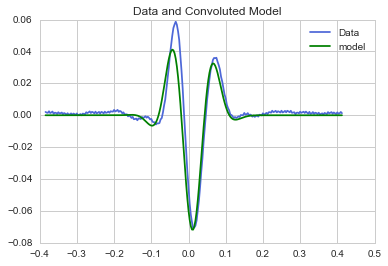

In [77]:
pl.plot(t,D, label = 'Data')
x,Modelf = psi1(findznot(0.05,0.02),8.577,0.05,0.02) #original q: 8.57718120805
pl.plot(x,Modelf*findahat(0.05,0.02), label = 'model', color='g')
pl.title('Data and Convoluted Model')
pl.legend()
pl.show()

Clearly these values seem to make the Model approximate the Dataset fairly closely. However we had assumed q prior. 

To make sure that this combination of variable values was indeed the optimal set of values we made corner plots of each combination of variabled, and varied them slightly around their supposed value. 
These values are Tau = .0212, p = .0534, q = 8.577, and the plots are below.

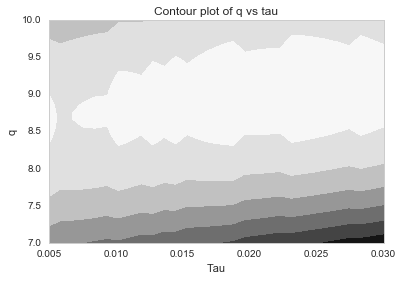

In [74]:
Tvec = np.linspace(.005,.03, 30)
qvec = np.linspace(7,10,30)

ChiMat1= np.zeros((len(Tvec),len(qvec)))
for ii in range (0,len(Tvec)):
    for jj in range (0, len(qvec)):
        T = Tvec[ii]
        q = qvec[jj]
        p = .0534
        x,Modelf = psi1(findznot(p,T),q,p, T)
        Dev = np.dot((D-Modelf*(findahat(p,T))),D-Modelf*(findahat(p,T)))
        ChiMat1[ii,jj] = Dev
        
levs=(np.linspace(0.001,.1,80))
pl.contourf(Tvec,qvec,(ChiMat1.T))
pl.title('Contour plot of q vs tau')
pl.xlabel('Tau')
pl.ylabel('q')
pl.show()

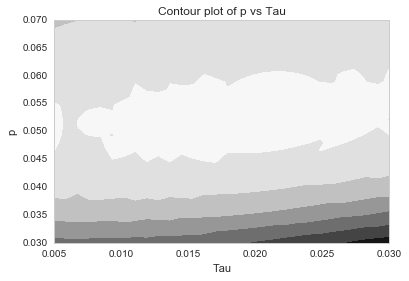

In [75]:
Tvec = np.linspace(.005,.03, 30)
pvec = np.linspace(.03,.07,30)
ChiMat2 = np.zeros((len(Tvec), len(pvec)))
for ii in range (0,len(Tvec)):
    for jj in range (0, len(pvec)):
        T = Tvec[ii]
        p = pvec[jj]
        q = 8.577
        x,Modelf = psi1(findznot(p,T),q,p, T)
        Dev = np.dot((D-Modelf*(findahat(p,T))),D-Modelf*(findahat(p,T)))
        ChiMat2[ii,jj] = Dev
levs=(np.linspace(0.001,.1,80))
pl.contourf(Tvec, pvec,(ChiMat2.T))
pl.title('Contour plot of p vs Tau')
pl.xlabel('Tau')
pl.ylabel('p')
pl.show()

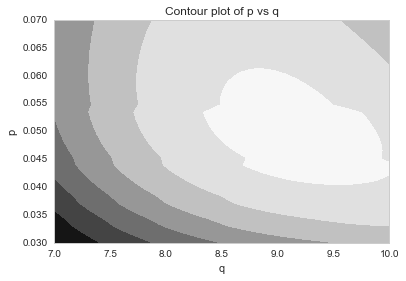

In [76]:
qvec = np.linspace(7,10,30)
pvec = np.linspace(.03,.07,30)
ChiMat3 = np.zeros((len(qvec), len(pvec)))
for ii in range (0,len(qvec)):
    for jj in range (0, len(pvec)):
        q = qvec[ii]
        p = pvec[jj]
        T = .0212
        x,Modelf = psi1(findznot(p,T),q,p, T)
        Dev = np.dot((D-Modelf*(findahat(p,T))),D-Modelf*(findahat(p,T)))
        ChiMat3[ii,jj] = Dev
levs=(np.linspace(0.001,.1,80))
pl.contourf(qvec, pvec,(ChiMat3.T))
pl.title('Contour plot of p vs q')
pl.xlabel('q')
pl.ylabel('p')
pl.show()

Moving q from 8.5 to 9, which the last contour plot seems to suggest, has no visible affect. Hence from these contour plots it can be shown that the values we calculated, Tau = .0212, p = .0534, q = 8.577, and our functions of A and z_not, are the optimal values!